In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import os, json

In [2]:
#start by reimporting data
#this time using batch size 32 and prefetching for performance
train = keras.utils.image_dataset_from_directory(
    directory='data/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True)
train = train.prefetch(32)
test = keras.utils.image_dataset_from_directory(
    directory='data/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True)
test = test.prefetch(32)
valid = keras.utils.image_dataset_from_directory(
    directory='data/valid/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True)
valid = valid.prefetch(32)

Found 58388 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


In [3]:
train.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 400), dtype=tf.float32, name=None))

In [4]:
list(train.take(1))

[(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
  array([[[[135., 152., 180.],
           [135., 152., 180.],
           [133., 153., 180.],
           ...,
           [241., 242., 234.],
           [250., 253., 246.],
           [233., 236., 229.]],
  
          [[134., 151., 179.],
           [133., 150., 178.],
           [134., 151., 179.],
           ...,
           [245., 246., 238.],
           [249., 250., 242.],
           [240., 243., 234.]],
  
          [[130., 146., 172.],
           [129., 146., 172.],
           [131., 148., 174.],
           ...,
           [245., 245., 235.],
           [244., 244., 234.],
           [239., 241., 230.]],
  
          ...,
  
          [[ 98., 112., 125.],
           [127., 137., 149.],
           [119., 125., 137.],
           ...,
           [138., 145., 161.],
           [144., 156., 170.],
           [143., 157., 170.]],
  
          [[126., 138., 154.],
           [139., 148., 163.],
           [113., 116., 131.],
    

In [5]:
#helper code
labelDict = {}
labels = os.listdir('data/test')
for i in range(len(labels)):
    labelDict[i] = labels[i]
labelDict[0]
def getSpecies(labelArray):
    return labelDict[list(labelArray).index(1)]
def dumpTrainHist(history, modelName):
    with open(f'{modelName}.json', 'w') as out:
        json.dump(history.history, out)

In [6]:
input_shape = (224,224,3)

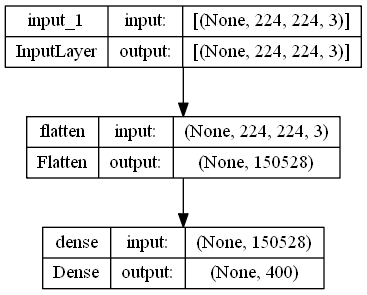

In [7]:
#model 1
#this will likely be horribly innacurate
basicNN = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(400, activation = 'softmax'),
])
basicNN.compile(optimizer = 'adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(basicNN, show_shapes=True)

In [8]:
hist = basicNN.fit(train, epochs=5, validation_data=test)
dumpTrainHist(hist, 'basicNN')

Epoch 1/5
1825/1825 [==============================] - 28s 15ms/step - loss: 51095.6406 - accuracy: 0.0250 - val_loss: 34760.0898 - val_accuracy: 0.0420
Epoch 2/5
1825/1825 [==============================] - 26s 14ms/step - loss: 35896.7344 - accuracy: 0.0627 - val_loss: 39502.2969 - val_accuracy: 0.0575
Epoch 3/5
1825/1825 [==============================] - 26s 14ms/step - loss: 33771.9336 - accuracy: 0.0914 - val_loss: 37816.2773 - val_accuracy: 0.0670
Epoch 4/5
1825/1825 [==============================] - 26s 14ms/step - loss: 32065.6699 - accuracy: 0.1214 - val_loss: 38520.6367 - val_accuracy: 0.0810
Epoch 5/5
1825/1825 [==============================] - 26s 14ms/step - loss: 30767.0352 - accuracy: 0.1471 - val_loss: 36618.1992 - val_accuracy: 0.0900


This model performs surprisingly well considering how simple it is, but it could definitely be improved. We will next try a simple convolutional model.

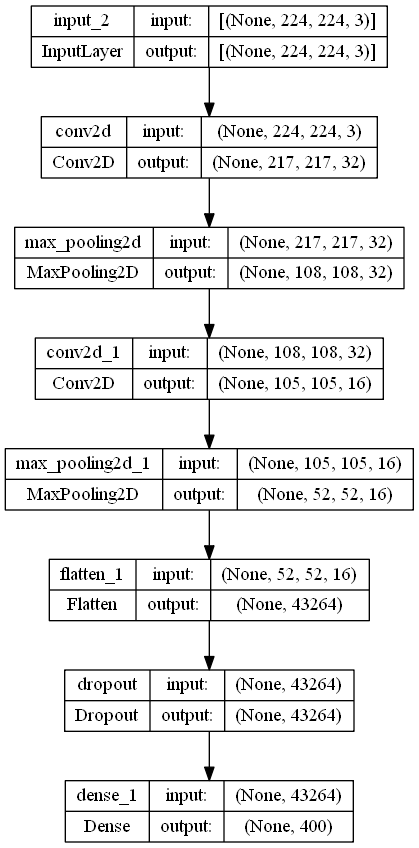

In [9]:
#model 2
#this will still be far too simple to be accurate
convNN = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, 8, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(16, 4, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(400, activation='softmax')
])
convNN.compile(optimizer = 'adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(convNN, show_shapes=True)

In [10]:
hist = convNN.fit(train, epochs=5, validation_data=test)
dumpTrainHist(hist, 'basicConvNN')

Epoch 1/5
1825/1825 [==============================] - 55s 29ms/step - loss: 6.3599 - accuracy: 0.0041 - val_loss: 5.9926 - val_accuracy: 0.0025
Epoch 2/5
1825/1825 [==============================] - 52s 28ms/step - loss: 5.9596 - accuracy: 0.0076 - val_loss: 6.0024 - val_accuracy: 0.0025
Epoch 3/5
1825/1825 [==============================] - 52s 28ms/step - loss: 5.9047 - accuracy: 0.0165 - val_loss: 6.0772 - val_accuracy: 0.0040
Epoch 4/5
1825/1825 [==============================] - 52s 29ms/step - loss: 5.8406 - accuracy: 0.0273 - val_loss: 6.1380 - val_accuracy: 0.0035
Epoch 5/5
1825/1825 [==============================] - 53s 29ms/step - loss: 5.7888 - accuracy: 0.0362 - val_loss: 6.3810 - val_accuracy: 0.0045


This model is less accurate at first than our simple model, likely due to the limited scope. It is taking a long time to train for minimal returns.
Training a useable model from scratch requires much more processing power than is availible.

In order to circumvent this, we will use transferred learning. Specifically, we will look into DenseNet, EfficientNet, and MobileNet.

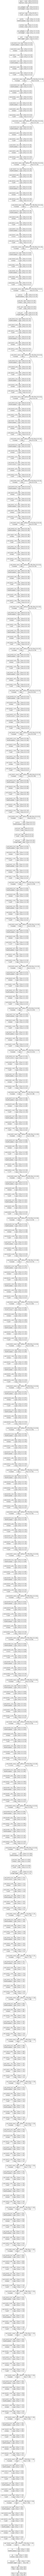

In [11]:
#model 3
#DenseNet121
dense121Raw = keras.applications.densenet.DenseNet121(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in dense121Raw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(dense121Raw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
dense121Model = keras.Model(dense121Raw.input, x)
dense121Model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(dense121Model, show_shapes=True)

In [12]:
hist = dense121Model.fit(train,epochs=5,validation_data=test)
dumpTrainHist(hist, 'Dense121')

Epoch 1/5
1825/1825 [==============================] - 114s 60ms/step - loss: 17.4272 - accuracy: 0.1031 - val_loss: 12.5658 - val_accuracy: 0.2245
Epoch 2/5
1825/1825 [==============================] - 106s 58ms/step - loss: 11.8470 - accuracy: 0.2467 - val_loss: 11.9650 - val_accuracy: 0.2935
Epoch 3/5
1825/1825 [==============================] - 106s 58ms/step - loss: 10.5512 - accuracy: 0.3089 - val_loss: 10.7275 - val_accuracy: 0.3440
Epoch 4/5
1825/1825 [==============================] - 106s 58ms/step - loss: 9.7548 - accuracy: 0.3511 - val_loss: 10.8969 - val_accuracy: 0.3355
Epoch 5/5
1825/1825 [==============================] - 106s 58ms/step - loss: 9.1538 - accuracy: 0.3858 - val_loss: 10.8899 - val_accuracy: 0.3785


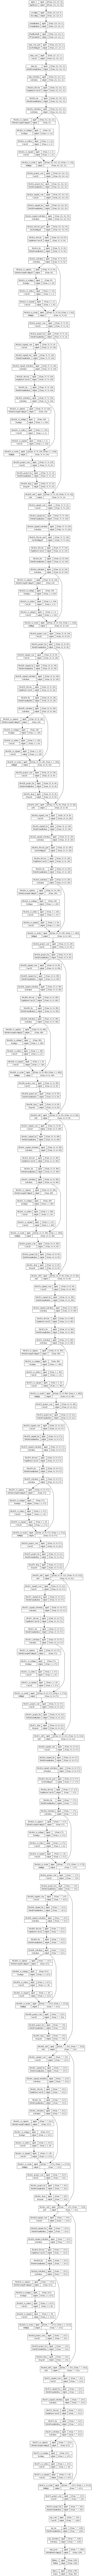

In [13]:
#model 4
#EfficientNetB0
effNetB0Raw = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in effNetB0Raw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(effNetB0Raw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
effNetB0Model = keras.Model(effNetB0Raw.input, x)
effNetB0Model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(effNetB0Model, show_shapes=True)

In [14]:
hist = effNetB0Model.fit(train,epochs=5,validation_data=test)
dumpTrainHist(hist, 'EfficientNetB0')

Epoch 1/5
1825/1825 [==============================] - 93s 49ms/step - loss: 2.1480 - accuracy: 0.6952 - val_loss: 0.5074 - val_accuracy: 0.9085
Epoch 2/5
1825/1825 [==============================] - 87s 48ms/step - loss: 1.0153 - accuracy: 0.8597 - val_loss: 0.3303 - val_accuracy: 0.9365
Epoch 3/5
1825/1825 [==============================] - 87s 48ms/step - loss: 0.8136 - accuracy: 0.8928 - val_loss: 0.2685 - val_accuracy: 0.9525
Epoch 4/5
1825/1825 [==============================] - 90s 49ms/step - loss: 0.6858 - accuracy: 0.9130 - val_loss: 0.3786 - val_accuracy: 0.9510
Epoch 5/5
1825/1825 [==============================] - 87s 48ms/step - loss: 0.5782 - accuracy: 0.9272 - val_loss: 0.2970 - val_accuracy: 0.9550


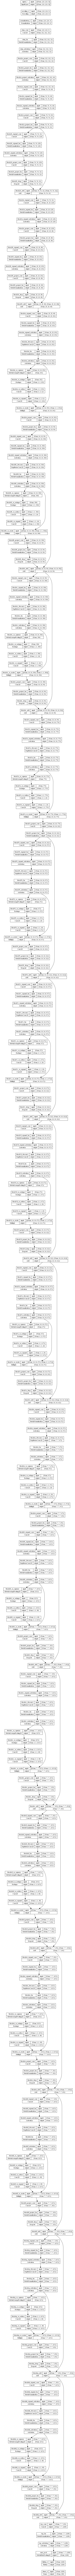

In [15]:
#model 5
#EfficientNetV2B0
effNetV2B0Raw = keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in effNetV2B0Raw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(effNetV2B0Raw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
effNetV2B0Model = keras.Model(effNetV2B0Raw.input, x)
effNetV2B0Model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(effNetV2B0Model, show_shapes=True)

In [16]:
hist = effNetV2B0Model.fit(train,epochs=5,validation_data=test)
dumpTrainHist(hist, 'EfficientNetB0V2')

Epoch 1/5
1825/1825 [==============================] - 82s 43ms/step - loss: 2.1448 - accuracy: 0.6670 - val_loss: 0.4084 - val_accuracy: 0.9145
Epoch 2/5
1825/1825 [==============================] - 76s 42ms/step - loss: 0.9902 - accuracy: 0.8468 - val_loss: 0.3283 - val_accuracy: 0.9365
Epoch 3/5
1825/1825 [==============================] - 76s 42ms/step - loss: 0.7906 - accuracy: 0.8829 - val_loss: 0.3939 - val_accuracy: 0.9375
Epoch 4/5
1825/1825 [==============================] - 76s 42ms/step - loss: 0.7375 - accuracy: 0.8982 - val_loss: 0.2340 - val_accuracy: 0.9610
Epoch 5/5
1825/1825 [==============================] - 78s 43ms/step - loss: 0.5934 - accuracy: 0.9183 - val_loss: 0.3195 - val_accuracy: 0.9535


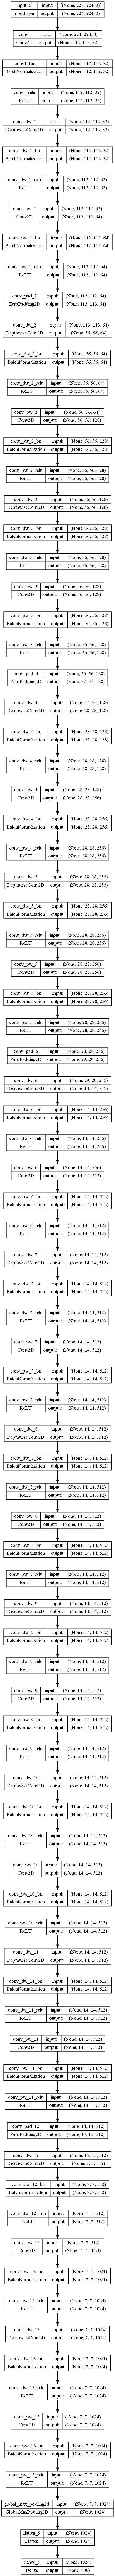

In [17]:
#model 6
#MobileNet
mobileNetRaw = keras.applications.MobileNet(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in mobileNetRaw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(mobileNetRaw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
mobileNetModel = keras.Model(mobileNetRaw.input, x)
mobileNetModel.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(mobileNetModel, show_shapes=True)

In [18]:
hist = mobileNetModel.fit(train,epochs=5,validation_data=test)
dumpTrainHist(hist, 'MobileNet')

Epoch 1/5
1825/1825 [==============================] - 51s 27ms/step - loss: 7.1562 - accuracy: 0.0918 - val_loss: 5.6469 - val_accuracy: 0.2015
Epoch 2/5
1825/1825 [==============================] - 52s 29ms/step - loss: 4.7969 - accuracy: 0.2563 - val_loss: 5.3233 - val_accuracy: 0.2490
Epoch 3/5
1825/1825 [==============================] - 52s 29ms/step - loss: 3.9891 - accuracy: 0.3407 - val_loss: 5.2513 - val_accuracy: 0.2665
Epoch 4/5
1825/1825 [==============================] - 50s 27ms/step - loss: 3.5085 - accuracy: 0.3968 - val_loss: 5.4181 - val_accuracy: 0.2825
Epoch 5/5
1825/1825 [==============================] - 49s 27ms/step - loss: 3.1442 - accuracy: 0.4435 - val_loss: 5.7993 - val_accuracy: 0.2915


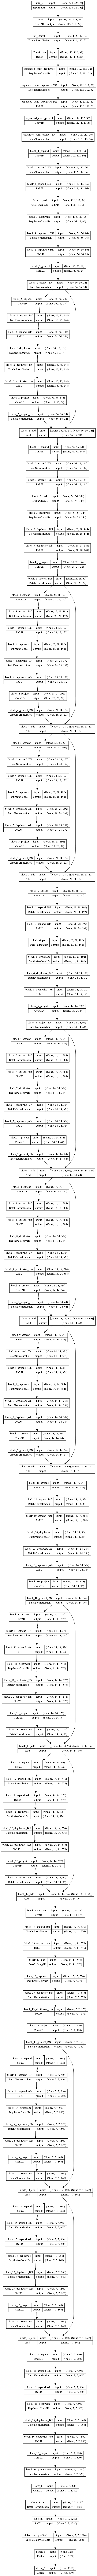

In [19]:
#model 7
#MobileNetV2
mobileNetV2Raw = keras.applications.MobileNetV2(
    include_top=False,
    input_shape=input_shape,
    pooling='max',
)
#freeze existing weights
for layer in mobileNetV2Raw.layers:
    layer.trainable=False
#add output layer
x = layers.Flatten()(mobileNetV2Raw.layers[-1].output)
x = layers.Dense(400, activation='softmax')(x)
mobileNetV2Model = keras.Model(mobileNetV2Raw.input, x)
mobileNetV2Model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
keras.utils.plot_model(mobileNetV2Model, show_shapes=True)

In [20]:
hist = mobileNetV2Model.fit(train,epochs=5,validation_data=test)
dumpTrainHist(hist, 'MobileNetV2')

Epoch 1/5
1825/1825 [==============================] - 63s 33ms/step - loss: 7.1150 - accuracy: 0.0666 - val_loss: 6.1781 - val_accuracy: 0.1125
Epoch 2/5
1825/1825 [==============================] - 63s 34ms/step - loss: 5.1027 - accuracy: 0.1920 - val_loss: 5.7318 - val_accuracy: 0.1640
Epoch 3/5
1825/1825 [==============================] - 64s 35ms/step - loss: 4.2588 - accuracy: 0.2733 - val_loss: 6.0969 - val_accuracy: 0.1630
Epoch 4/5
1825/1825 [==============================] - 62s 34ms/step - loss: 3.7200 - accuracy: 0.3361 - val_loss: 6.1300 - val_accuracy: 0.1760
Epoch 5/5
1825/1825 [==============================] - 64s 35ms/step - loss: 3.3184 - accuracy: 0.3814 - val_loss: 6.2262 - val_accuracy: 0.1845
